# Feature Engineering 1: From Variables to Features

### Imports and getting set up

In [80]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.feature_selection import SelectKBest, f_classif
import statsmodels.api as sm


### DB Connection & Call

In [2]:
confile = list(pd.read_csv('../../dbcon.csv'))
postgres_db = 'studentsperformance'
db_connection = 'postgresql://{}:{}@{}:{}/{}'.format(confile[0], confile[1], confile[2], confile[3], postgres_db)

In [3]:
query = '''
SELECT *
FROM studentsperformance
;'''

students_df = pd.read_sql(query, db_connection)

In [4]:
display(
    students_df.head(),
    students_df.info(),
    students_df.isna().mean()
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
gender                         1000 non-null object
race/ethnicity                 1000 non-null object
parental level of education    1000 non-null object
lunch                          1000 non-null object
test preparation course        1000 non-null object
math score                     1000 non-null int64
reading score                  1000 non-null int64
writing score                  1000 non-null int64
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


None

gender                         0.0
race/ethnicity                 0.0
parental level of education    0.0
lunch                          0.0
test preparation course        0.0
math score                     0.0
reading score                  0.0
writing score                  0.0
dtype: float64

#### Are the exam score variables normally distributed? If not, apply a Box-Cox transformation. Does anything change?

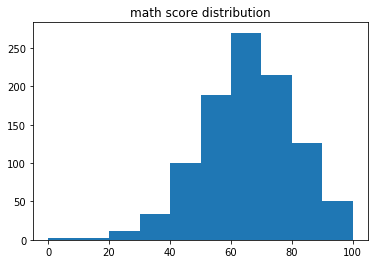

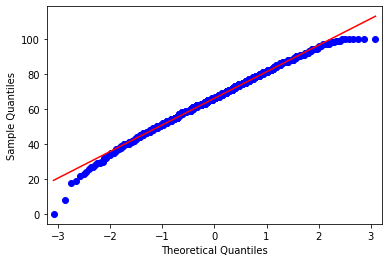

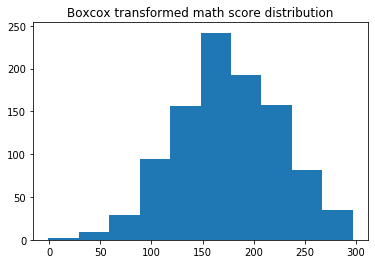

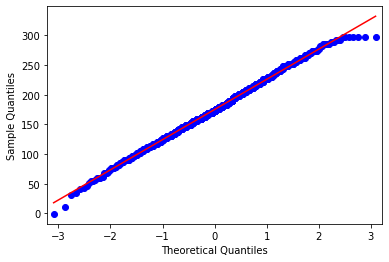

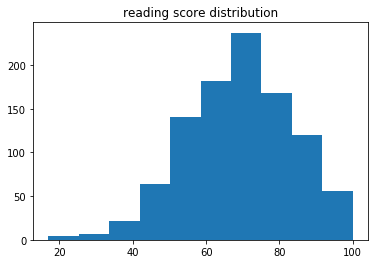

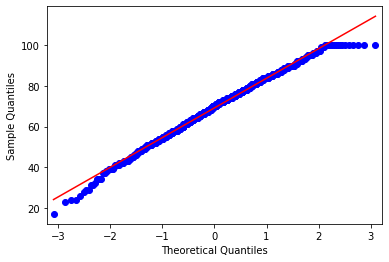

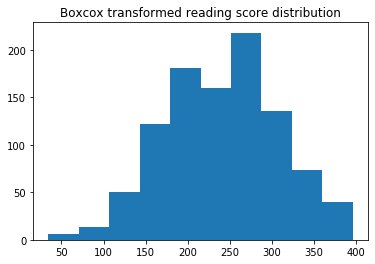

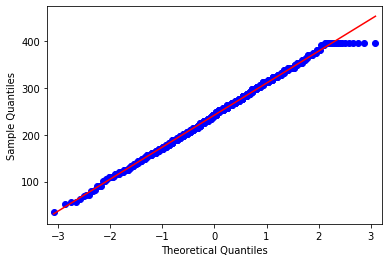

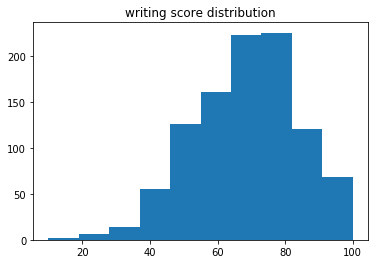

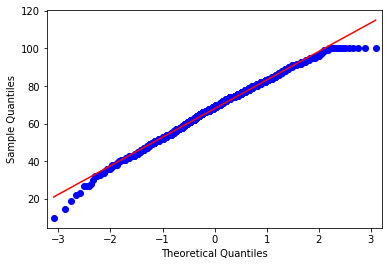

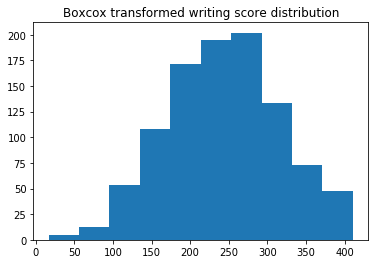

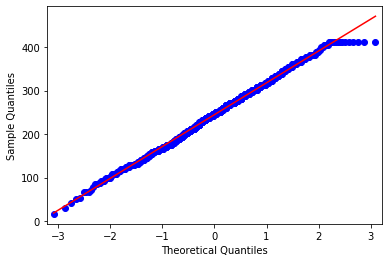

In [74]:
depvars = ['math score', 'reading score', 'writing score']
trans_score = pd.DataFrame()
students_df[depvars] = students_df[depvars].replace(0, 0.001)
for i in range(len(depvars)):
    plt.title('{} distribution'.format(depvars[i]))
    plt.hist(students_df[depvars[i]])
    plt.show()
    sm.qqplot(students_df[depvars[i]], line='s')
    plt.show()
    
    trans_score[depvars[i]], _ = st.boxcox(students_df[depvars[i]])
    plt.title('Boxcox transformed {} distribution'.format(depvars[i]))
    plt.hist(trans_score[depvars[i]])
    plt.show()
    sm.qqplot(trans_score[depvars[i]], line='s')
    plt.show()

<span style="color:blue">The distributions look normal, however slightly skewed.  After boxcox transformation, it appears to correct one of the tails of the normal distribution.</span>

#### Say we want to use a single variable for the exam scores as our target. For this purpose, create a new variable by taking a weighted average of the exam scores. Check whether this new variable is normally distributed. If it's not normally distributed, apply a Box-Cox transformation and check whether or not the transformed variable is normally distributed.

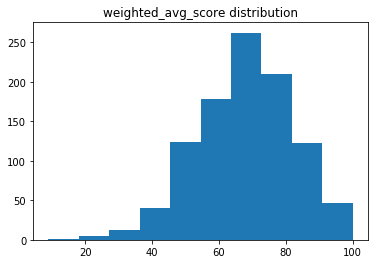

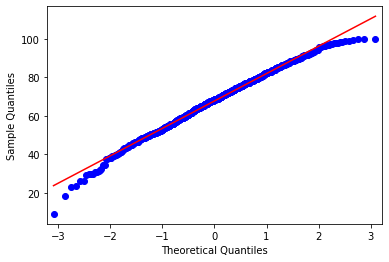

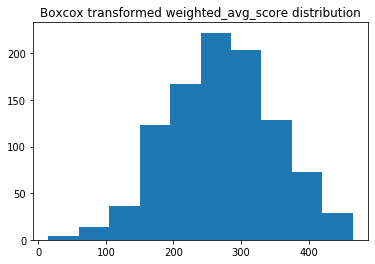

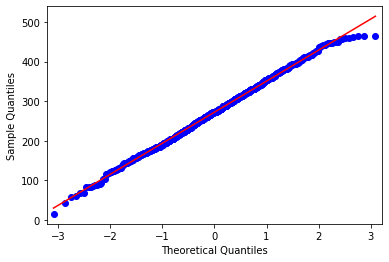

In [90]:
#Weights for math, reading, writing
weights = pd.Series([1, 1, 1])
weights = weights / sum(weights)
students_df['weighted_avg_score'] = ((weights[0])*(students_df['math score']) + 
                                     (weights[1])*(students_df['reading score']) + 
                                     (weights[2])*(students_df['writing score']))
plt.title('{} distribution'.format('weighted_avg_score'))
plt.hist(students_df['weighted_avg_score'])
plt.show()
sm.qqplot(students_df['weighted_avg_score'], line='s')
plt.show()

trans_score['weighted_avg_score'], _ = st.boxcox(students_df['weighted_avg_score'])
plt.title('Boxcox transformed {} distribution'.format('weighted_avg_score'))
plt.hist(trans_score['weighted_avg_score'])
plt.show()
sm.qqplot(trans_score['weighted_avg_score'], line='s')
plt.show()

<span style="color:blue">The distribution is similar with the same affect after the transformation</span>

#### Which variables seem related to the target variable (the newly created variable in the previous question)? If our goal is to explain the determinants of success in exams, which variables in our dataset might be useful?

In [91]:
students_df['weighted_avg_bins'] = pd.cut(students_df['math score'], bins=[0, 60, 70, 80, 90, 101], labels=['F', 'D', 'C', 'B', 'A'], right=False)

In [94]:
features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for feat in features:
    studentct = pd.crosstab(students_df['weighted_avg_bins'], students_df[feat])
    display(studentct)

gender,female,male
weighted_avg_bins,,
F,197,126
D,143,125
C,104,112
B,51,84
A,23,35


race/ethnicity,group A,group B,group C,group D,group E
weighted_avg_bins,,,,,
F,42,71,113,72,25
D,22,54,95,72,25
C,16,36,62,67,35
B,5,21,33,43,33
A,4,8,16,8,22


parental level of education,associate's degree,bachelor's degree,high school,master's degree,some college,some high school
weighted_avg_bins,,,,,,
F,72,27,79,17,64,64
D,52,35,54,9,69,49
C,38,28,43,15,52,40
B,39,16,17,12,30,21
A,21,12,3,6,11,5


lunch,free/reduced,standard
weighted_avg_bins,,
F,175,148
D,93,175
C,65,151
B,15,120
A,7,51


test preparation course,completed,none
weighted_avg_bins,,
F,87,236
D,95,173
C,88,128
B,56,79
A,32,26
